# ... continued from data cleaning project

In [3]:
import json
import os
import cv2
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline

### Retrieving list of folder names from txt file

In [4]:
# Reading list of folders of cropped images from a text file
with open('cropped_image_dirs.txt', 'r') as cr:
    cropped_image_dirs = json.loads(cr.read())

cropped_image_dirs

['./dataset/cropped/yuliya_levchenko',
 './dataset/cropped/lionel_messi',
 './dataset/cropped/serena_williams',
 './dataset/cropped/virat_kohli',
 './dataset/cropped/maria_sharapova',
 './dataset/cropped/roger_federer']

### Going into each folder to get list of names of cropped images

In [5]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'yuliya_levchenko': ['./dataset/cropped/yuliya_levchenko/yuliya_levchenko26.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko36.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko14.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko24.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko8.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko18.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko5.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko34.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko30.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko57.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko19.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko53.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko55.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko2.png',
  './dataset/cropped/yuliya_levchenko/yuliya_levchenko63.png',
  './dataset/cropped/yuliya_levchenko/

In [6]:
len(celebrity_file_names_dict.values())

6

## Open an image to test

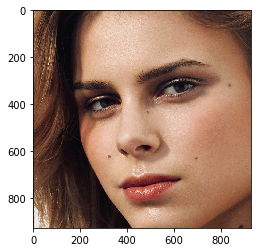

In [7]:
cropped_image = cv2.imread('./dataset/cropped/yuliya_levchenko/yuliya_levchenko45.png')
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
plt.imshow(cropped_image)

## Wavelet Transform

In [8]:
import numpy as np
import pywt
import cv2

def w2d(img, mode='haar', level=1):
    imArray = img
    # Datatype conversion
    # Convert to grayscale
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    
    # Convert to float
    imArray = np.float32(imArray)
    imArray /= 255;
    
    # Compute coefficients
    coeffs = pywt.wavedec2(imArray,mode,level=level)
    
    # Process Coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;
    
    # Reconstruction
    imArray_H = pywt.waverec2(coeffs_H,mode);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H  

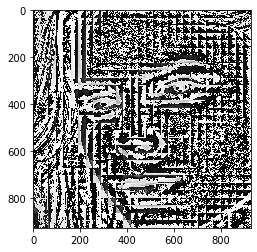

In [9]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har,cmap='gray')

### Generate a number for each celebrity name

In [10]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1

class_dict    

{'yuliya_levchenko': 0,
 'lionel_messi': 1,
 'serena_williams': 2,
 'virat_kohli': 3,
 'maria_sharapova': 4,
 'roger_federer': 5}

In [11]:
X = []
y = []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img,(32,32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har,(32,32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])
        
        

In [12]:
len(X[0])

4096

In [13]:
32*32*3 + 32*32

4096

In [14]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(421, 4096)

# Model Training

In [15]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [17]:
print(len(X_train),len(X_test))

315 106


In [18]:
pipe = Pipeline([('scaler', StandardScaler()),('svc',SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7830188679245284

In [19]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        20
           1       0.89      0.80      0.84        30
           2       0.60      0.92      0.73        13
           3       1.00      0.80      0.89        10
           4       0.69      0.81      0.75        27
           5       1.00      0.17      0.29         6

    accuracy                           0.78       106
   macro avg       0.84      0.72      0.72       106
weighted avg       0.82      0.78      0.78       106



## Use GridSearchCV to test many different models to find optimum config

In [20]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [21]:
model_params = {
    'svm':  {
        'model': svm.SVC(gamma = 'auto', probability = True),
        'params':{  'svc__C':[1,10,100,1000],
                    'svc__kernel':['rbf','linear']}
            },
    'random_forest':{
        'model': RandomForestClassifier(),
        'params':{  'randomforestclassifier__n_estimators':[1,5,10]}
                    },
    'logistic_regression':  {
        'model': LogisticRegression(solver='liblinear', multi_class = 'auto'),
        'params':{'logisticregression__C':[1,5,10]}
                            }
}

In [22]:
import pandas as pd

In [23]:
scores = []
best_estimators = {}
import pandas as pd
for algo,mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model':algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
results_df = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])
results_df

,model,best_score,best_params
0,svm,0.841270,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.657143,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.828571,{'logisticregression__C': 1}


In [24]:
best_estimators

{'svm': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('svc',
                  SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                      coef0=0.0, decision_function_shape='ovr', degree=3,
                      gamma='auto', kernel='linear', max_iter=-1,
                      probability=True, random_state=None, shrinking=True,
                      tol=0.001, verbose=False))],
          verbose=False),
 'random_forest': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('randomforestclassifier',
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='auto',
                                   

In [25]:
best_estimators['svm'].score(X_test,y_test)

0.8490566037735849

In [26]:
best_estimators['random_forest'].score(X_test,y_test)

0.6509433962264151

In [28]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8679245283018868

In [29]:
best_clf = best_estimators['svm']

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[18,  0,  1,  0,  1,  0],
       [ 2, 26,  0,  0,  2,  0],
       [ 1,  0, 12,  0,  0,  0],
       [ 0,  1,  0,  9,  0,  0],
       [ 2,  0,  2,  0, 23,  0],
       [ 1,  1,  1,  0,  1,  2]])

Text(69.0, 0.5, 'Truth')

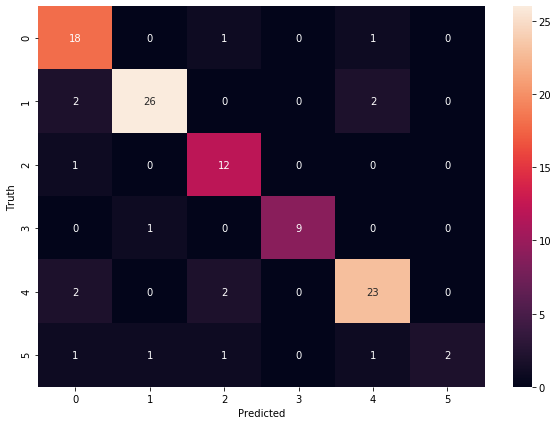

In [32]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [33]:
class_dict

{'yuliya_levchenko': 0,
 'lionel_messi': 1,
 'serena_williams': 2,
 'virat_kohli': 3,
 'maria_sharapova': 4,
 'roger_federer': 5}

### Save model to joblib

In [35]:
!pip install joblib
import joblib 
joblib.dump(best_clf,'saved_model.pkl')

['saved_model.pkl']

### Save class dictionary

In [36]:
import json
with open('class_dictionary.json','w') as f:
    f.write(json.dumps(class_dict))